In [40]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from IPython.display import clear_output

filename = lambda x:f"/Users/rainy21/IPL1/single-photon-interference/LASER/B-1/B-1_DoubleSlit_{str(x)}.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  volt = np.array(volt)
  volt = volt / max(volt)
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  volt = origninal_volt
  volt = np.array(volt)
  volt = volt / max(volt)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

device = th.device('cpu')
GAP_DOUBLE_SLIT = {
  14: 356e-6,
  15: 406e-6,
  16: 457e-6,
}

pos, volt = get_data(16)
pos_arg = (1.95 <= pos) & (pos <= 8.45)
pos_range = (1.95e-3, 8.449999e-3, len(pos[pos_arg]))

In [36]:
I0 = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[16], dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
eps=1e-10
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))

loss: 0.49050457057678987
transform: 0.004899581666441418
lambda: 650.0000000014873 nm


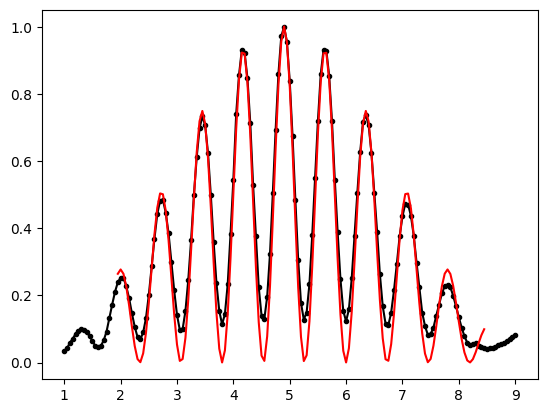

R2: 0.9460101707865793


Text(0.5, 1.0, 'Double Slit Interference Pattern (No.16)')

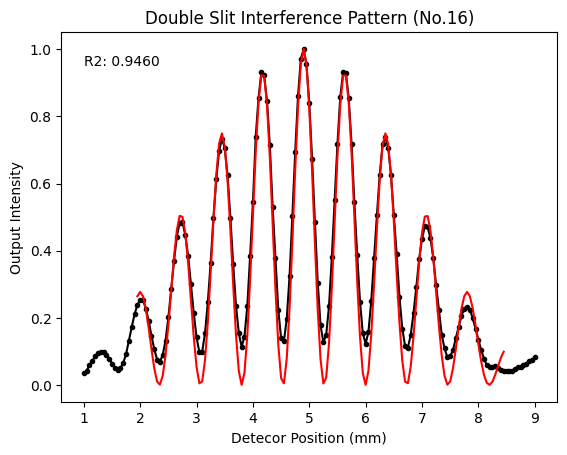

In [37]:
optimizer = th.optim.Adam([transform, k, L, h, b, I0], lr=1e-7)
pos, volt = get_data(16)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)
for i in range(10000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta = 1/2 * k * b * th.sin(theta)
  gamma = 1/2 * k * h * th.sin(theta)
  I = I0 * th.square(th.sin(beta) / (beta+eps)) * th.square(th.cos(gamma))
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")

plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
plt.plot(x * 1e3, I.detach().numpy(), color='red')
plt.text(1, 0.95, f"R2: {float(R2):.4f}")
plt.xlabel("Detecor Position (mm)")
plt.ylabel("Output Intensity")
plt.title("Double Slit Interference Pattern (No.16)")

In [4]:
gamma

tensor([-1.2239e+01, -1.2038e+01, -1.1838e+01, -1.1637e+01, -1.1437e+01,
        -1.1236e+01, -1.1035e+01, -1.0835e+01, -1.0634e+01, -1.0433e+01,
        -1.0233e+01, -1.0032e+01, -9.8315e+00, -9.6308e+00, -9.4302e+00,
        -9.2295e+00, -9.0289e+00, -8.8283e+00, -8.6276e+00, -8.4270e+00,
        -8.2263e+00, -8.0257e+00, -7.8251e+00, -7.6244e+00, -7.4238e+00,
        -7.2231e+00, -7.0225e+00, -6.8218e+00, -6.6212e+00, -6.4206e+00,
        -6.2199e+00, -6.0193e+00, -5.8186e+00, -5.6180e+00, -5.4174e+00,
        -5.2167e+00, -5.0161e+00, -4.8154e+00, -4.6148e+00, -4.4141e+00,
        -4.2135e+00, -4.0129e+00, -3.8122e+00, -3.6116e+00, -3.4109e+00,
        -3.2103e+00, -3.0096e+00, -2.8090e+00, -2.6084e+00, -2.4077e+00,
        -2.2071e+00, -2.0064e+00, -1.8058e+00, -1.6051e+00, -1.4045e+00,
        -1.2039e+00, -1.0032e+00, -8.0257e-01, -6.0193e-01, -4.0129e-01,
        -2.0064e-01, -1.8686e-06,  2.0064e-01,  4.0128e-01,  6.0193e-01,
         8.0257e-01,  1.0032e+00,  1.2039e+00,  1.4

# Integral

In [65]:
I0 = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[15], dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
eps = 1e-10
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))

loss: 0.17083822771749924
transform: 0.005442065496552863
lambda: 650.000000000052 nm


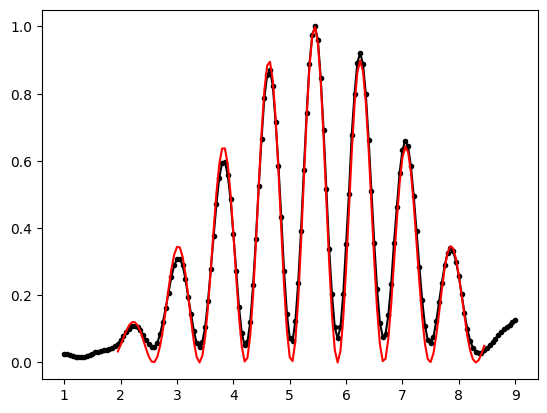

R2: 0.9821334380091458


In [66]:
optimizer = th.optim.Adam([transform, k, L, h, b], lr=1e-7)
pos, volt = get_data(15)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)
for i in range(20000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta = 1/2 * k * b * th.sin(theta)
  gamma = 1/2 * k * h * th.sin(theta)
  I = I0 * th.square(th.sin(beta) / (beta+eps)) * th.square(th.cos(gamma))
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")



In [67]:
I0 = I0
h = h
lamb0 = 2 * th.pi / k
z = th.linspace(-0.2, 0.2, 101)
alpha = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
k_tensor = k * (1 + z)
p = 1 / (1 + th.square(z / alpha))
b = b
L = L
transform = transform
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta = 1/2 * k_tensor[:, None] * b * th.sin(theta)[None, :]
gamma = 1/2 * k_tensor[:, None] * h * th.sin(theta)[None, :]
eps = 1e-10
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
I = th.sum(I * p[:, None], axis=0) / th.sum(p)

loss: 0.07889652072325813
alpha: 0.022284782701425497


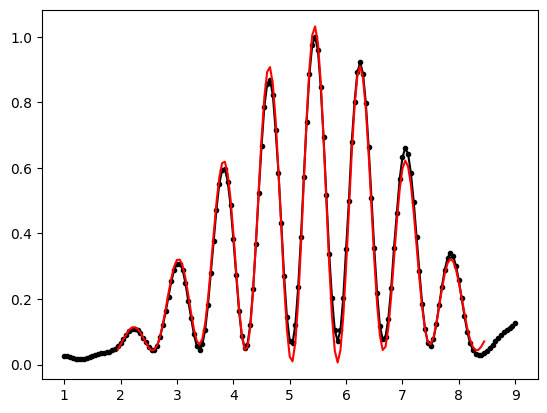

R2: 0.9917488707226004


Text(0.5, 1.0, 'Doulbe Slit with Line Width(No.16)')

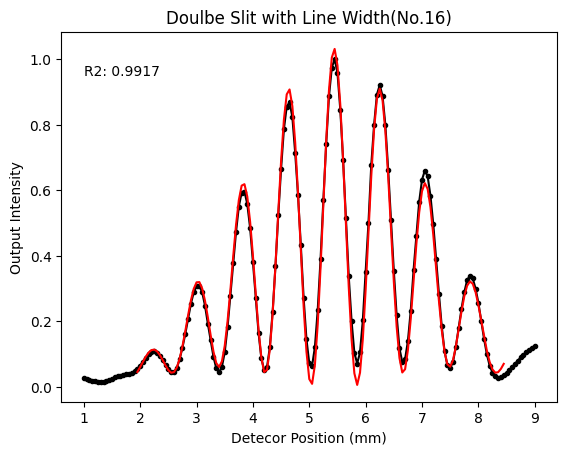

In [77]:
optimizer = th.optim.Adam([alpha, transform, k, L, h, b, I0], lr=1e-6)
pos, volt = get_data(15)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)
for i in range(5000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  k_tensor = k * (1 + z)
  beta = 1/2 * k_tensor[:, None] * b * th.sin(theta)[None, :]
  gamma = 1/2 * k_tensor[:, None] * h * th.sin(theta)[None, :]
  eps = 1e-10
  p = 1 / (1 + th.square(z / alpha))
  I1 = I0 * th.square(th.sin(beta) / (beta+eps)) * th.square(th.cos(gamma))
  I = th.sum(I1 * p[:, None], axis=0) / th.sum(p)
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"alpha: {float(alpha)}")
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()
R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")

plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
plt.plot(x * 1e3, I.detach().numpy(), color='red')
plt.text(1, 0.95, f"R2: {float(R2):.4f}")
plt.xlabel("Detecor Position (mm)")
plt.ylabel("Output Intensity")
plt.title("Doulbe Slit with Line Width(No.16)")

Text(0.0077, 0.95, 'FWHM: 0.0003159 /nm')

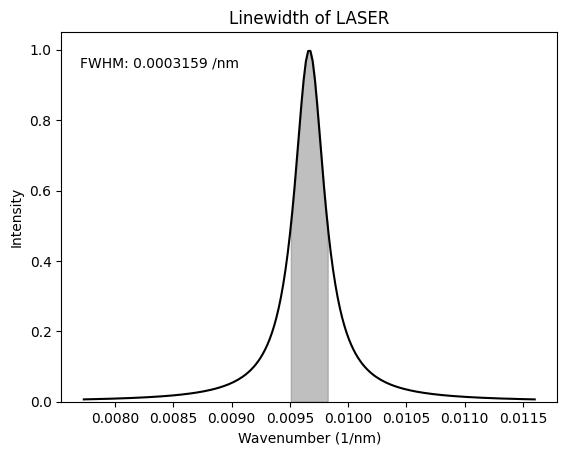

In [24]:
# Lorentzian Graph
lambda0 = 2 * th.pi / k
z = th.linspace(-0.2, 0.2, 200)
k_lorentzian = k * (1 + z)
p = 1 / (1 + th.square(z / alpha))
lambda_lorentzian = 2 * th.pi / k_lorentzian
plt.plot(k_lorentzian.detach() / 1e9, p.detach(), color='black')
# Gray Area
z_prime = th.linspace(-alpha, alpha, 100)
k_prime = k * (1 + z_prime)
p_prime = 1 / (1 + th.square( z_prime / alpha))
plt.fill_between(k_prime.detach() / 1e9, p_prime.detach(), color='gray', alpha=0.5)
plt.ylim(0,)

plt.xlabel("Wavenumber (1/nm)")
plt.ylabel("Intensity")
plt.title("Linewidth of LASER")
plt.text(0.0077, 0.95, "FWHM: "+f"{2 * float(alpha) * k / 1e9:.7f} /nm")

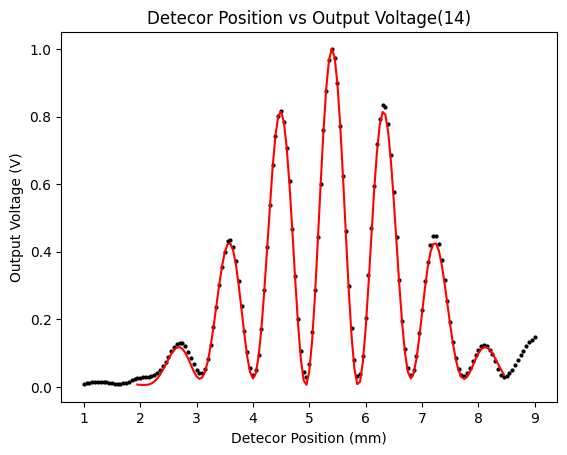

In [14]:
plot_data(14)
plt.plot(x * 1e3, I.detach().numpy(), color='red')


# Asymmetry

In [58]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from IPython.display import clear_output

filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-3/B-3_AsymmDoubleSlit_Blocker2.33_14.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  volt = np.array(volt)
  volt = volt / max(volt)
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  volt = origninal_volt
  volt = np.array(volt)
  volt = volt / max(volt)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

device = th.device('cpu')
GAP_DOUBLE_SLIT = {
  14: 356e-6,
  15: 406e-6,
  15: 457e-6,
}

pos, volt = get_data(14)
pos_arg = (2.1 <= pos) & (pos <= 7.8)
pos_range = (2.1e-3, 7.7999e-3, len(pos[pos_arg]))

In [59]:
A = th.tensor(0.5, dtype=th.float64, device=device, requires_grad=True)
B = th.tensor(0.5, dtype=th.float64, device=device, requires_grad=True)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[14], dtype=th.float64, device=device, requires_grad=True)
a = th.tensor(0.25e-3, dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
phi = th.tensor(0, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta1 = 1/2 * k * a * th.sin(theta)
beta2 = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
eps=0
I = th.square(A * th.sin(beta1) / beta1) + th.square(B * th.sin(beta2) / beta2) \
  + 2 * A * B * th.sin(beta1) / beta1 * th.sin(beta2) / beta2 * th.cos(gamma + phi)

loss: 0.7336994301314521
transform: 0.0051915006183776416
lambda: 650.0000989617834 nm


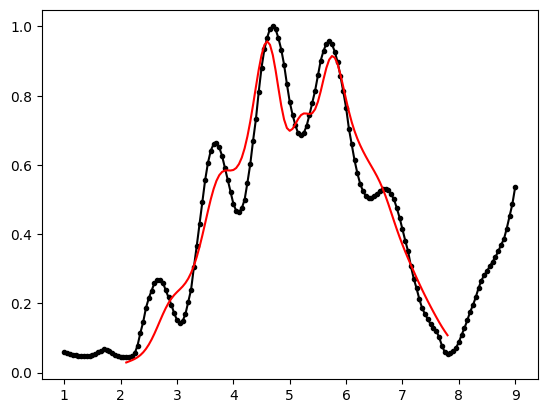

In [65]:
optimizer = th.optim.Adam([transform, k, L, h, a, b, A, B, phi], lr=1e-7)
pos, volt = get_data(14)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)

for i in range(10000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta1 = 1/2 * k * a * th.sin(theta)
  beta2 = 1/2 * k * b * th.sin(theta)
  gamma = 1/2 * k * h * th.sin(theta)
  I = th.square(A * th.sin(beta1) / beta1) + th.square(B * th.sin(beta2) / beta2) \
    + 2 * A * B * th.sin(beta1) / beta1 * th.sin(beta2) / beta2 * th.cos(gamma + phi)
  loss = th.sum(th.square(I - volt_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

# Blub

In [100]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from IPython.display import clear_output

filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/BLUB/F-2/F-2_DoubleSlit_14_550_4.csv"
POSITION_COL = "detector_position"
VOLTAGE_COL = "count"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  volt = np.array(volt)
  pos = np.array(pos[::5])
  counts = np.array([volt[::5], volt[1::5], volt[2::5], volt[3::5], volt[4::5]])
  volt = np.mean(counts, axis=0)
  counts = counts / max(volt)
  volt = volt / max(volt)
  return pos, volt, counts

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  volt = origninal_volt
  volt = np.array(volt)
  volt = volt / max(volt)
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

device = th.device('cpu')
GAP_DOUBLE_SLIT = {
  14: 356e-6,
  15: 406e-6,
  15: 457e-6,
}

pos, volt, counts = get_data(14)

left = 1.00; right = 7.95
pos_arg = (left <= pos) & (pos <= right)
pos_range = (left * 1e-3, right * 1e-3 - 1e-7, len(pos[pos_arg]))

In [101]:
I0 = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
lamb = 650e-9
k = th.tensor(2 * th.pi / lamb, dtype=th.float64, device=device, requires_grad=True)
h = th.tensor(GAP_DOUBLE_SLIT[14], dtype=th.float64, device=device, requires_grad=True)
b = th.tensor(85e-6, dtype=th.float64, device=device, requires_grad=True)
L = th.tensor(0.489, dtype=th.float64, device=device, requires_grad=True)
C = th.tensor(0.05, dtype=th.float64, device=device, requires_grad=True)
transform = th.tensor(5e-3, dtype=th.float64, device=device, requires_grad=True)
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta = 1/2 * k * b * th.sin(theta)
gamma = 1/2 * k * h * th.sin(theta)
eps=0
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma)) + C

loss: 6.812389238238703
transform: 0.004915866255545376
lambda: 650.0000006237681 nm
[tensor(0.0049, dtype=torch.float64, requires_grad=True), tensor(9666438.9248, dtype=torch.float64, requires_grad=True), tensor(0.4983, dtype=torch.float64, requires_grad=True), tensor(0.0004, dtype=torch.float64, requires_grad=True), tensor(0.0001, dtype=torch.float64, requires_grad=True), tensor(0.0880, dtype=torch.float64, requires_grad=True), tensor(0.8926, dtype=torch.float64, requires_grad=True)]


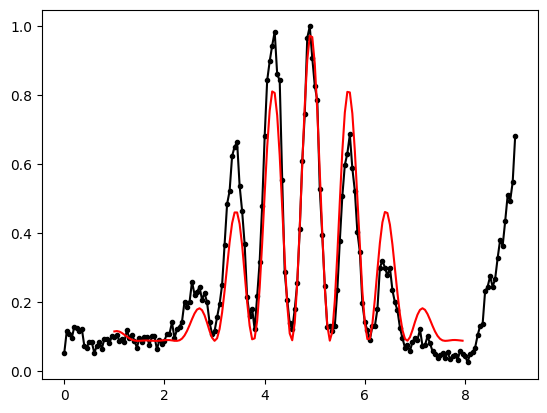

R2: 0.8947397319818927


Text(0.5, 1.0, 'Double Slit Interference Pattern (No.14)')

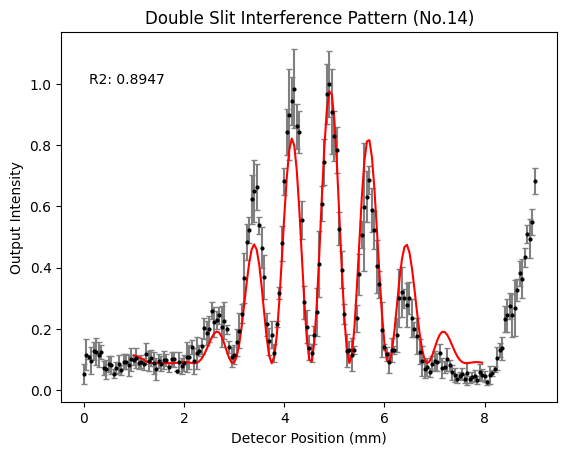

In [102]:
optimizer = th.optim.Adam([transform, k, L, h, b, C, I0], lr=1e-4)
pos, volt, counts = get_data(14)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)
counts_tensor = th.tensor(counts[:, pos_arg], dtype=th.float64, device=device)
for i in range(10000):
  optimizer.zero_grad()
  theta = ((x-transform) / L)
  beta = 1/2 * k * b * theta
  gamma = 1/2 * k * h * theta
  I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma)) + C
  loss = th.sum(th.square(I - counts_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"transform: {float(transform)}")
    print(f"lambda: {2 * th.pi / float(k) * 1e9} nm")
    print([transform, k, L, h, b, C, I0])
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()

R2 = 1 - th.sum(th.square(volt_tensor - I)) / th.sum(th.square(volt_tensor - th.mean(counts_tensor)))
print(f"R2: {float(R2)}")

plt.errorbar(pos, counts.mean(axis=0), yerr=counts.std(axis=0), fmt='o', color='black', ms=2, capsize=2, capthick=1, ecolor='gray')
plt.plot(x * 1e3, I.detach().numpy(), color='red')
plt.text(0.1, 1, f"R2: {float(R2):.4f}")
plt.xlabel("Detecor Position (mm)")
plt.ylabel("Output Intensity")
plt.title("Double Slit Interference Pattern (No.14)")

In [104]:
I0 = I0
h = h
lamb0 = 2 * th.pi / k
z = th.linspace(-0.2, 0.2, 101)
alpha = th.tensor(1, dtype=th.float64, device=device, requires_grad=True)
k_tensor = k * (1 + z)
p = 1 / (1 + th.square(z / alpha))
b = b
L = L
transform = transform
x = th.linspace(*pos_range)
theta = ((x-transform) / L)
beta = 1/2 * k_tensor[:, None] * b * th.sin(theta)[None, :]
gamma = 1/2 * k_tensor[:, None] * h * th.sin(theta)[None, :]
eps = 1e-10
I = I0 * th.square(th.sin(beta) / beta) * th.square(th.cos(gamma))
I = th.sum(I * p[:, None], axis=0) / th.sum(p)

loss: 14.371209197152833
alpha: 0.9077541904016344


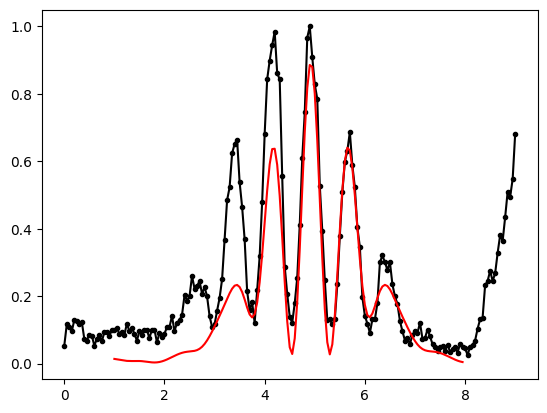

R2: 0.6883168014005049


Text(0.5, 1.0, 'Doulbe Slit with Line Width(No.16)')

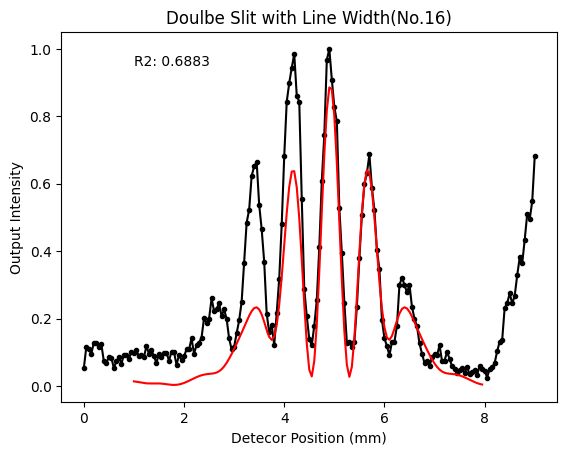

In [105]:
optimizer = th.optim.Adam([alpha], lr=1e-5)
pos, volt, counts = get_data(15)
volt_tensor = th.tensor(volt[pos_arg], dtype=th.float64, device=device)
counts_tensor = th.tensor(counts[:, pos_arg], dtype=th.float64, device=device)
I1 = I0 * th.square(th.sin(beta) / (beta+eps)) * th.square(th.cos(gamma))
I1 = I1.detach()
for i in range(10000):
  optimizer.zero_grad()
  # I1 = I0 * th.square(th.sin(beta) / (beta+eps)) * th.square(th.cos(gamma))
  I = th.sum(I1 * p[:, None], axis=0) / th.sum(p)
  loss = th.sum(th.square(I - counts_tensor))
  loss.backward()
  optimizer.step()
  if i % 1000 == 0:
    clear_output(wait=True)
    print(f"loss: {float(loss)}")
    print(f"alpha: {float(alpha)}")
    plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
    plt.plot(x * 1e3, I.detach().numpy(), color='red')
    plt.show()
R2 = 1 - th.sum(th.square(counts_tensor - I)) / th.sum(th.square(counts_tensor - th.mean(volt_tensor)))
print(f"R2: {float(R2)}")

plt.plot(pos, volt, color='black', marker='o', mfc='black', mec='black', ms=3)
plt.plot(x * 1e3, I.detach().numpy(), color='red')
plt.text(1, 0.95, f"R2: {float(R2):.4f}")
plt.xlabel("Detecor Position (mm)")
plt.ylabel("Output Intensity")
plt.title("Doulbe Slit with Line Width(No.16)")

Text(0.0077, 0.95, 'FWHM: 0.0003159 /nm')

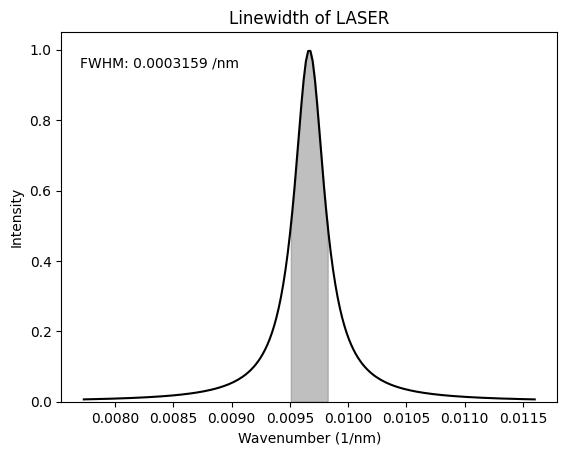

In [ ]:
# Lorentzian Graph
lambda0 = 2 * th.pi / k
z = th.linspace(-0.2, 0.2, 200)
k_lorentzian = k * (1 + z)
p = 1 / (1 + th.square(z / alpha))
lambda_lorentzian = 2 * th.pi / k_lorentzian
plt.plot(k_lorentzian.detach() / 1e9, p.detach(), color='black')
# Gray Area
z_prime = th.linspace(-alpha, alpha, 100)
k_prime = k * (1 + z_prime)
p_prime = 1 / (1 + th.square( z_prime / alpha))
plt.fill_between(k_prime.detach() / 1e9, p_prime.detach(), color='gray', alpha=0.5)
plt.ylim(0,)

plt.xlabel("Wavenumber (1/nm)")
plt.ylabel("Intensity")
plt.title("Linewidth of LASER")
plt.text(0.0077, 0.95, "FWHM: "+f"{2 * float(alpha) * k / 1e9:.7f} /nm")

In [108]:
counts

array([[0.01262626, 0.21464646, 0.11363636, 0.16414141, 0.12626263,
        0.1010101 , 0.16414141, 0.12626263, 0.07575758, 0.08838384,
        0.13888889, 0.1010101 , 0.05050505, 0.05050505, 0.08838384,
        0.07575758, 0.13888889, 0.1010101 , 0.06313131, 0.1010101 ,
        0.12626263, 0.06313131, 0.08838384, 0.1010101 , 0.06313131,
        0.11363636, 0.12626263, 0.12626263, 0.07575758, 0.12626263,
        0.05050505, 0.07575758, 0.13888889, 0.1010101 , 0.06313131,
        0.07575758, 0.07575758, 0.06313131, 0.13888889, 0.11363636,
        0.12626263, 0.2020202 , 0.08838384, 0.12626263, 0.17676768,
        0.06313131, 0.11363636, 0.11363636, 0.23989899, 0.16414141,
        0.18939394, 0.29040404, 0.26515152, 0.2020202 , 0.22727273,
        0.27777778, 0.32828283, 0.17676768, 0.12626263, 0.07575758,
        0.11363636, 0.12626263, 0.13888889, 0.3030303 , 0.35353535,
        0.46717172, 0.47979798, 0.68181818, 0.65656566, 0.60606061,
        0.58080808, 0.41666667, 0.23989899, 0.23